In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from os import listdir
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder

In [8]:
mfcc_files = ['../data/mfcc/' + f for f in listdir('../data/mfcc/') if '_mfcc.pkl' in f]
target_files = ['../data/target/' + f for f in listdir('../data/target/') if '_target.pkl' in f]

mfcc_files.sort()
target_files.sort()

In [9]:
def reload(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [10]:
mfcc_reloaded = [reload(f) for f in mfcc_files]
target_reloaded = [reload(f) for f in target_files]

In [11]:
mfcc_files

['../data/mfcc/en12280_mfcc.pkl',
 '../data/mfcc/es8171_mfcc.pkl',
 '../data/mfcc/fr6175_mfcc.pkl',
 '../data/mfcc/ru8081_mfcc.pkl',
 '../data/mfcc/zh3544_mfcc.pkl']

In [12]:
target_files

['../data/target/en12280_target.pkl',
 '../data/target/es8171_target.pkl',
 '../data/target/fr6175_target.pkl',
 '../data/target/ru8081_target.pkl',
 '../data/target/zh3544_target.pkl']

In [13]:
X = np.concatenate(mfcc_reloaded)

In [14]:
y = np.concatenate(target_reloaded)

In [15]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [16]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [17]:
model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (20, 157, 1)))
model.add(Conv2D(filters = 10, kernel_size = 10, activation = 'relu', input_shape = (20, 157, 1)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [18]:
earlystop = EarlyStopping(patience=5)

In [19]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[earlystop],
    epochs=25
)

Epoch 1/25
897/897 [==============================] - 98s 108ms/step - loss: 1.2865 - acc: 0.4428 - val_loss: 0.8963 - val_acc: 0.6605
Epoch 2/25
897/897 [==============================] - 98s 109ms/step - loss: 0.9052 - acc: 0.6474 - val_loss: 0.7980 - val_acc: 0.6885
Epoch 3/25
897/897 [==============================] - 93s 104ms/step - loss: 0.7810 - acc: 0.7024 - val_loss: 0.7191 - val_acc: 0.7290
Epoch 4/25
897/897 [==============================] - 94s 105ms/step - loss: 0.6969 - acc: 0.7352 - val_loss: 0.7218 - val_acc: 0.7222
Epoch 5/25
897/897 [==============================] - 94s 105ms/step - loss: 0.6380 - acc: 0.7533 - val_loss: 0.6564 - val_acc: 0.7552
Epoch 6/25
897/897 [==============================] - 93s 104ms/step - loss: 0.5784 - acc: 0.7775 - val_loss: 0.6355 - val_acc: 0.7641
Epoch 7/25
897/897 [==============================] - 93s 104ms/step - loss: 0.5338 - acc: 0.7966 - val_loss: 0.6330 - val_acc: 0.7693
Epoch 8/25
897/897 [==============================] - 9

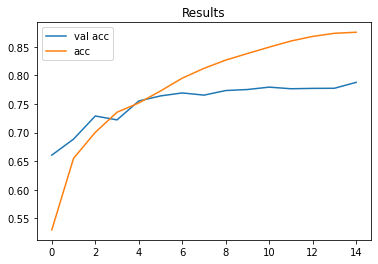

In [20]:
# plot
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend()
plt.title('Results');

In [51]:
model.save('../models/cnn02252021.h5', save_format='h5')

In [19]:
from sklearn.metrics import confusion_matrix

In [17]:
reloaded_model = tensorflow.keras.models.load_model('../models/cnn02252021.h5')

In [18]:
y_out = np.apply_along_axis(np.argmax, axis=1, arr=y_test)

In [20]:
cm = confusion_matrix(y_out, reloaded_model.predict_classes(X_test))

In [21]:
cm

array([[2895,   55,   25,   59,   26],
       [  90, 1805,    9,  121,    3],
       [  29,   25, 1424,   60,    5],
       [  91,  128,   31, 1767,   20],
       [  78,    6,    2,    6,  803]])

In [31]:
x = np.true_divide(cm, cm.sum(axis=1, keepdims=True))

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(69.0, 0.5, 'Predicted')

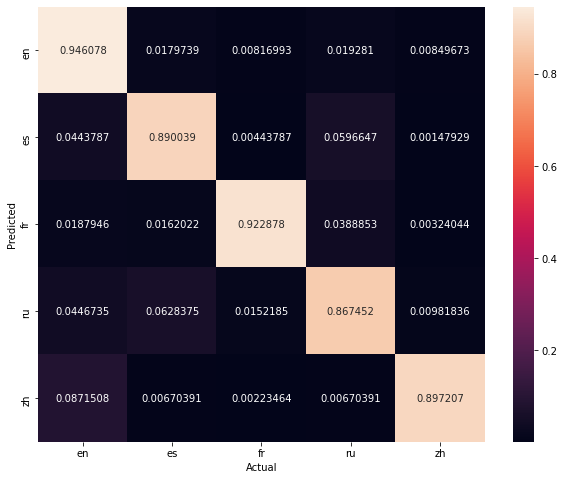

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(x, annot=True, fmt='g', xticklabels=['en', 'es', 'fr', 'ru', 'zh'], yticklabels=['en', 'es', 'fr', 'ru', 'zh'])
plt.xlabel("Actual")
plt.ylabel("Predicted")